In [6]:
import os
import joblib

import matplotlib.pyplot as plt
import numpy as np

from data import *
from utils import *
from train import *
from models import *

In [7]:
forecasters = train(
    dataset="airline-passengers.csv",  # or raw numpy array
    window_size=12,
    roc_mode="cluster",
    n_clusters=5,
    metric="euclidean",
    save_to= False                # will write artifacts/forecasters.pkl
)
print("Trained", len(forecasters), "forecasters:")
for f in forecasters:
    print("  -", f.model.__class__.__name__,
          "| raw windows:", len(f.raw_windows),
          "| centers:", getattr(f, "centers", None).shape if f.roc_mode=="cluster" else "")

Trained 3 forecasters:
  - ARIMAModel | raw windows: 0 | centers: (5, 12)
  - RFModel | raw windows: 0 | centers: (5, 12)
  - LinearRegressionModel | raw windows: 0 | centers: (5, 12)


In [8]:
loader = airline.Airline(path=None, normalize=True, as_numpy=True)
data = loader.data

# We only need the first 75% to get train+val splits
X_train, y_train, X_val, y_val, X_test, y_test = windowing(
    data,
    train_window_size=12,
    horizon=1,
    train_ratio=0.5,
    val_ratio=0.25
)

print(f"Validation: {X_val.shape[0]} windows")

Validation: 24 windows


In [9]:
from sklearn.cluster import KMeans

def validate_forecasters(forecasters, X_val, y_val, roc_mode, n_clusters):
    if roc_mode == "raw":
        # assign each window to the single best-forecasting model
        for f in forecasters:
            f.raw_windows = []            # reset
        for x, y in zip(X_val, y_val):
            errors = [
                (f.predict(x.reshape(1, -1))[0] - y)**2
                for f in forecasters
            ]
            best_idx = np.argmin(errors)
            forecasters[best_idx].raw_windows.append(x)
    else:
        # 1) global KMeans clustering of all val windows
        arr = X_val.reshape(len(X_val), -1)
        km  = KMeans(n_clusters=n_clusters, random_state=0).fit(arr)
        centers = km.cluster_centers_
        labels  = km.labels_
        # clear previous clusters
        for f in forecasters:
            f.clusters = []
            f.centers  = []
        # 2) for each cluster, pick the expert model
        for k in range(n_clusters):
            idxs = np.where(labels == k)[0]
            ws   = X_val[idxs]
            ys   = y_val[idxs]
            # compute average MSE per model on this cluster
            mse_per_model = []
            for f in forecasters:
                preds = f.predict(ws.reshape(len(ws), -1))
                mse_per_model.append(np.mean((preds - ys)**2))
            best_idx = int(np.argmin(mse_per_model))
            # assign this whole cluster to that forecaster
            f_best = forecasters[best_idx]
            f_best.clusters.append(ws)
            f_best.centers.append(centers[k])

# forecasters = train(...)  # if you didn't already
validate_forecasters(
    forecasters,
    X_val, y_val,
    roc_mode="raw",    # or "raw"
    n_clusters=3
)

# quick sanity check
for f in forecasters:
    n = len(f.raw_windows) if f.roc_mode=="raw" else len(f.clusters)
    print(f"{f.model.__class__.__name__} got {n} RoCs")

ARIMAModel got 5 RoCs
RFModel got 5 RoCs
LinearRegressionModel got 5 RoCs


Plotting RoCs for ARIMAModel (cluster mode)…


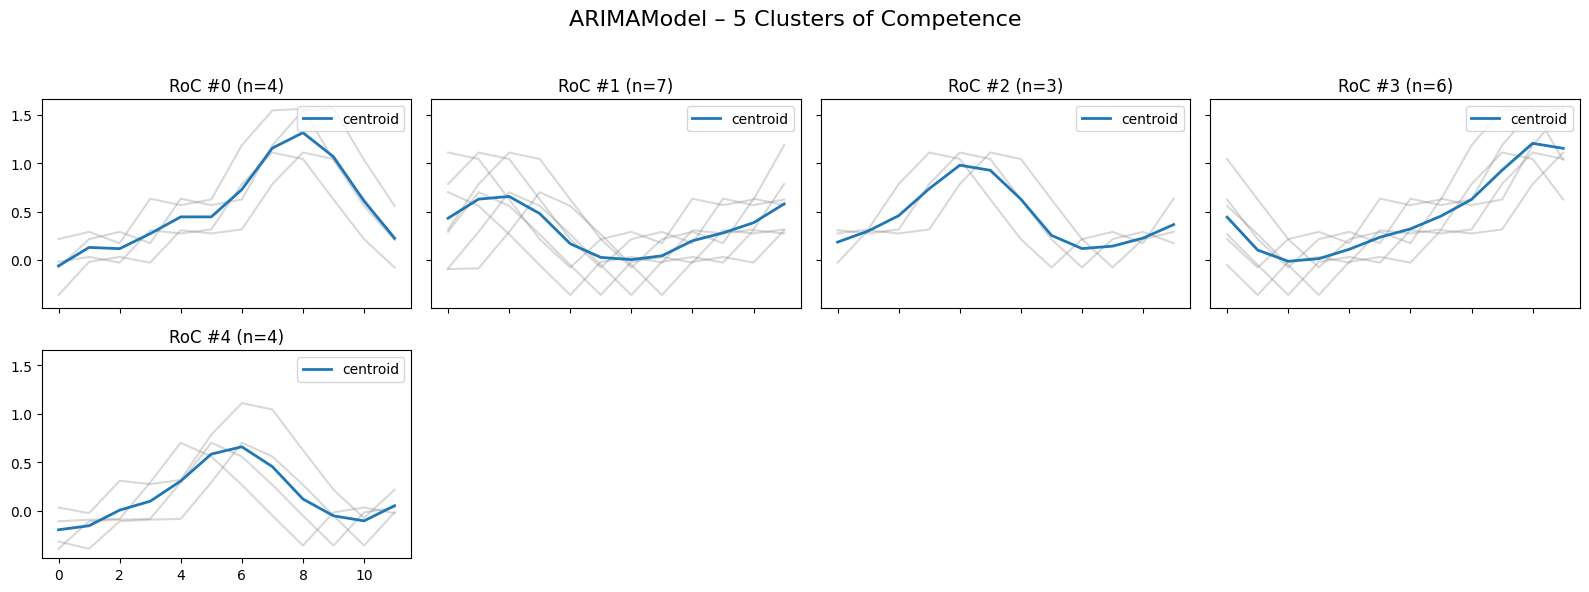

Plotting RoCs for RFModel (cluster mode)…


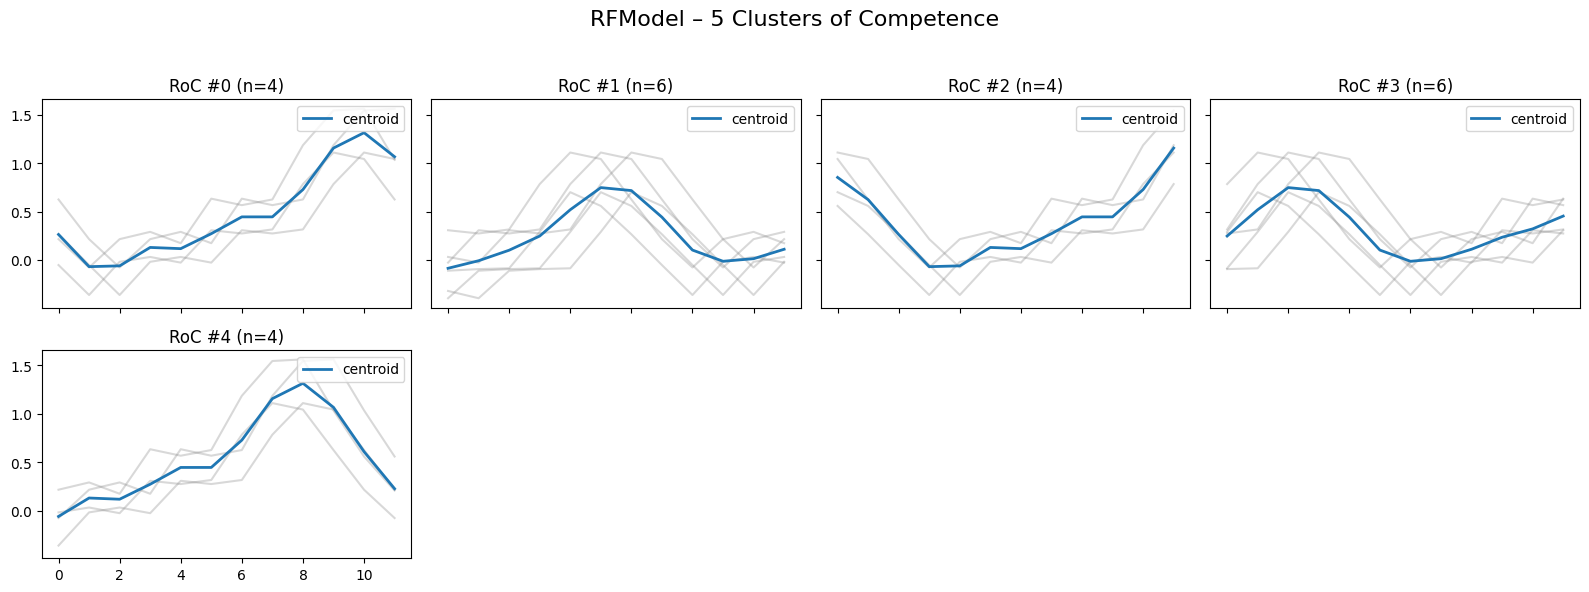

Plotting RoCs for LinearRegressionModel (cluster mode)…


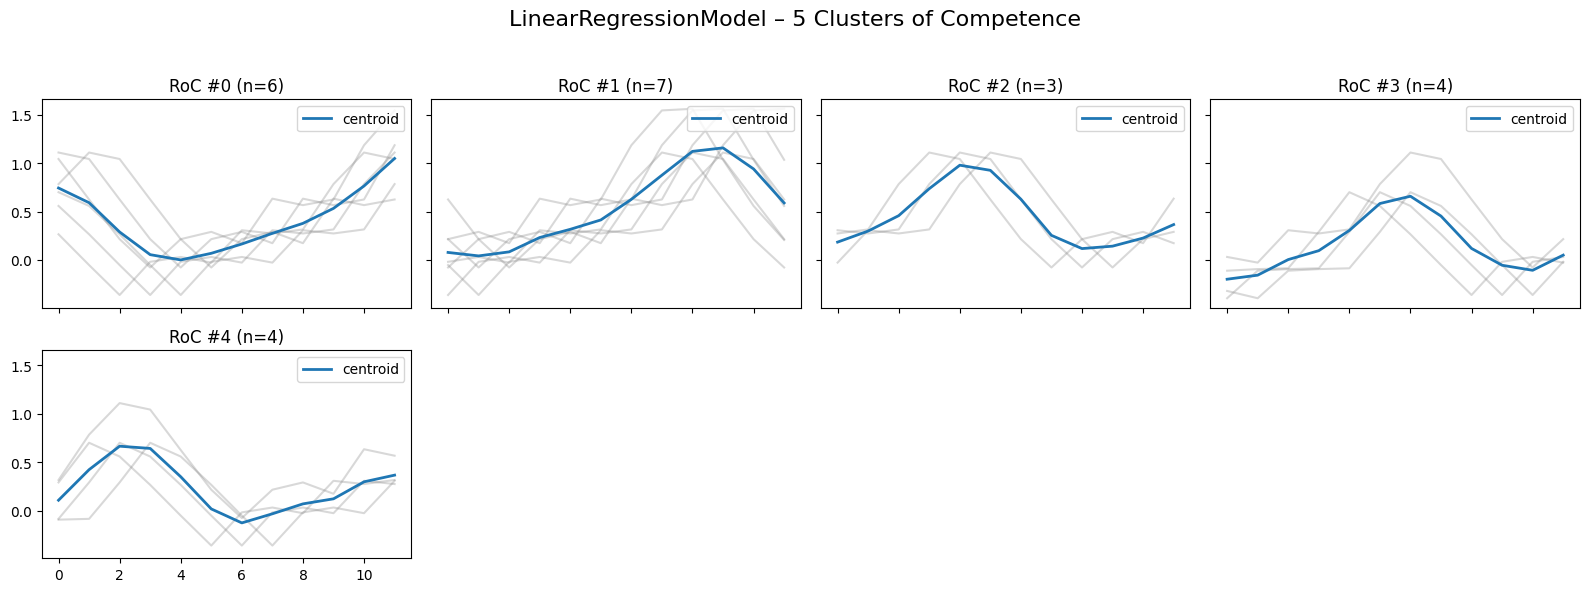

In [10]:
import matplotlib.pyplot as plt

for f in forecasters:
    name = f.model.__class__.__name__
    print(f"Plotting RoCs for {name} ({f.roc_mode} mode)…")

    if f.roc_mode == "raw":
        # all windows in one plot
        plt.figure(figsize=(6,4))
        for w in f.raw_windows:
            plt.plot(w, color="gray", alpha=0.3)
        plt.title(f"{name} – Raw RoC (n={len(f.raw_windows)})")
        plt.xlabel("Time step")
        plt.ylabel("Value")
        plt.show()

    else:  # cluster mode
        K = len(f.clusters)
        cols = min(K, 4)
        rows = (K + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=True, sharey=True)
        axes = axes.flatten()

        for i, ax in enumerate(axes[:K]):
            # plot all windows in this cluster
            for w in f.clusters[i]:
                ax.plot(w, color="gray", alpha=0.3)
            # plot the center
            center = f.centers[i]
            ax.plot(center, color="C0", lw=2, label="centroid")
            ax.set_title(f"RoC #{i} (n={len(f.clusters[i])})")
            ax.legend(loc="upper right")
        # hide any unused subplots
        for ax in axes[K:]:
            ax.axis("off")

        fig.suptitle(f"{name} – {K} Clusters of Competence", fontsize=16)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()

In [11]:
# split into train/val/test (50/25/25)
_, _, _, _, X_test, y_test = windowing(
    data,
    train_window_size=12,   # same window_size as before
    horizon=1,
    train_ratio=0.5,
    val_ratio=0.25
)

print(f"Test set: {X_test.shape[0]} windows of length {X_test.shape[1]}")

Test set: 24 windows of length 12


In [12]:

preds = []
winners = []

for w in X_test:
    best_dist = np.inf
    best_f   = None

    # pick the model whose RoC is closest to this window
    for f in forecasters:
        d = f.distance_to_roc(w).min()
        if d < best_dist:
            best_dist = d
            best_f    = f

    # forecast one step ahead
    p = best_f.predict(w.reshape(1, -1))[0]
    preds.append(p)
    winners.append(best_f.model.__class__.__name__)

preds = np.array(preds)
print("Done forecasting on test set.")

Done forecasting on test set.


In [14]:
# Cell: invert normalization & compute metrics
from sklearn.metrics import mean_squared_error
import numpy as np

# bring back to original passenger‐counts
y_true = loader.inverse_transform(y_test)
y_pred = loader.inverse_transform(preds)

mse   = mean_squared_error(y_true, y_pred)
rmse  = np.sqrt(mse)

print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")

Test MSE: 16624.291
Test RMSE: 128.935


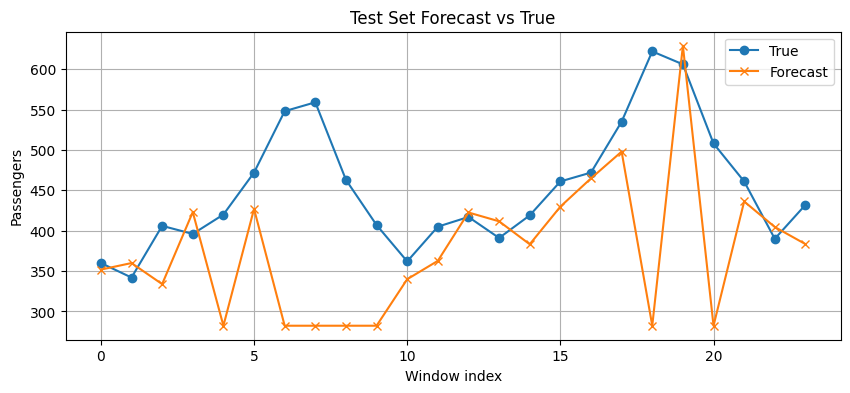

In [15]:
# Cell: plot true vs. forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_true, label="True", marker='o')
plt.plot(y_pred, label="Forecast", marker='x')
plt.title("Test Set Forecast vs True")
plt.xlabel("Window index")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()